In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt      
import pickle
import pandas as pd
import seaborn as sns


In [4]:
all_data ={
    'primates' : pd.read_csv(f'../subject_data/primates.csv'),
    'monkeys' : pd.read_csv(f'../subject_data/monkeys.csv'),
    'humans' : pd.read_csv(f'../subject_data/human_ver2.csv'),
    'Bento' : pd.read_csv(f'../subject_data/Bento_Data.csv'),
    'Magneto' : pd.read_csv(f'../subject_data/Magneto_Data.csv'),
} 

NB_CONTEXT_TYPES = 10

def swap_cols(row):
    if row['Distractor'] > row['Target']:
        row['Distractor'], row['Target'] = row['Target'], row['Distractor']
    return row
def save(x, filename):
    pickle.dump(x, open(f'{filename}.pkl', 'wb'))

In [5]:
I1, C1, C1_extended, I1n, C2 = dict(), dict(), dict(), dict(), dict()

swap = True
C2_DIM = 45 if swap else 90

for subject_name in ['primates', 'humans', 'monkeys', 'Bento', 'Magneto']:
    data = all_data[subject_name]
    valid_info = data[(data['isValidSample_Test']==1)&(data['isValidSample']==1)].sort_values(by=['imageNr'])
    I1[subject_name] = list(valid_info.groupby('imageNr').mean()['Response'])

    C1[subject_name] = [np.mean(I1[subject_name][i::NB_CONTEXT_TYPES]) for i in range(NB_CONTEXT_TYPES)]
    C1_extended[subject_name] = [C1[subject_name][i % NB_CONTEXT_TYPES] for i in range(600)]
    
    I1n[subject_name] = np.array(I1[subject_name])-np.array(C1_extended[subject_name])
    
    valid_info['context cat'] = valid_info['imageNr']%NB_CONTEXT_TYPES
    if swap:
    # Apply the function to swap the columns as needed to consider the same target object pair
        valid_info = valid_info.apply(swap_cols, axis=1)
    grouped_info = valid_info.sort_values(by=['imageNr']).groupby(['imageNr', 'Target','Distractor']).mean()
    C2[subject_name] = grouped_info.reset_index().groupby(['context cat', 'Target','Distractor']).mean()['Response']
    C2[subject_name] = C2[subject_name].sort_index().values.reshape((NB_CONTEXT_TYPES, C2_DIM))


In [6]:
beh_sig_sbj = {
    'I1' :  I1,
    'C1' :  C1,
    'I1n' :  I1n,
    'C2' : C2
}
context_to_num = {'full context': 0, 'incongruent context':1, 
                  'no context':2, 'no object':3, 'blur context':4, 
                  'blur object':5, 'blur boundary':6, 'min context':7, 
                  'jigsaw context':8, 'textured context':9}

In [30]:
sns.color_palette(["teal", "coral"])#FDE3DB, F36F63
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
#cmap_coral = ListedColormap(['FDE3DB' 'F36F63'])
coral_max = [1.0, 0.498, 0.314]
coral_min = [0.992, 0.890, 0.859]

cmap_coral = LinearSegmentedColormap.from_list('cmap_coral', ['w','#E07E75'])

cmap_coral
teal_max = [0.012, 0.506, 0.506]
teal_min = [0.843, 0.882, 0.890]
cmap_teal= LinearSegmentedColormap.from_list('cmap_teal', [teal_min,teal_max])
cmap_purple = LinearSegmentedColormap.from_list('cmap_purple', ['w','#9699C4'])

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_3407/3729746716.py:18: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


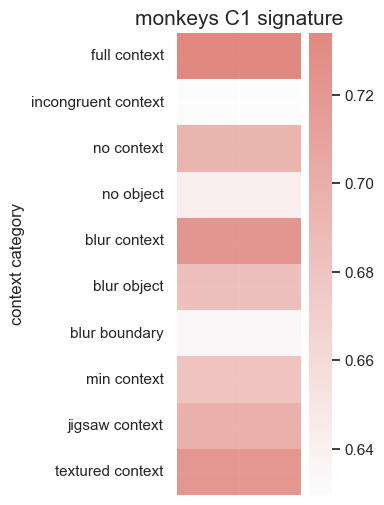

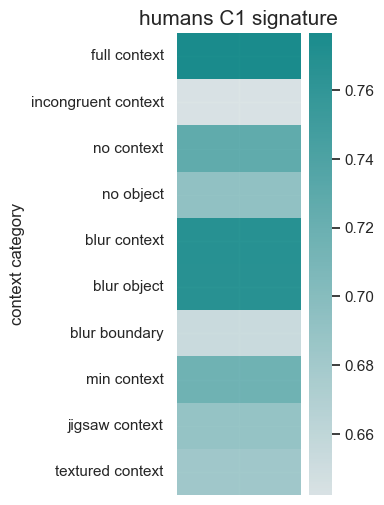

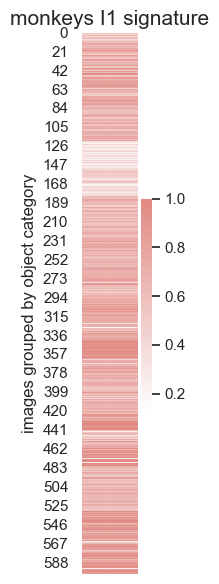

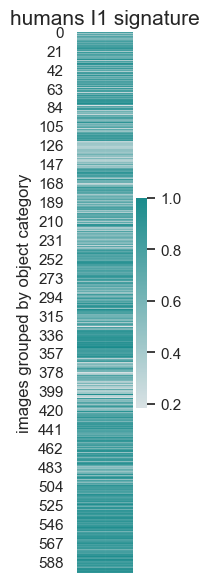

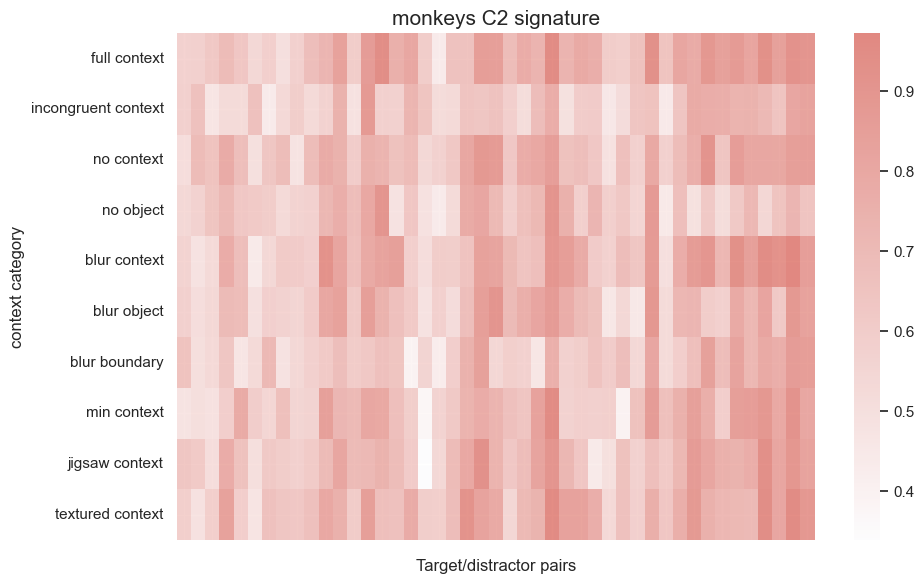

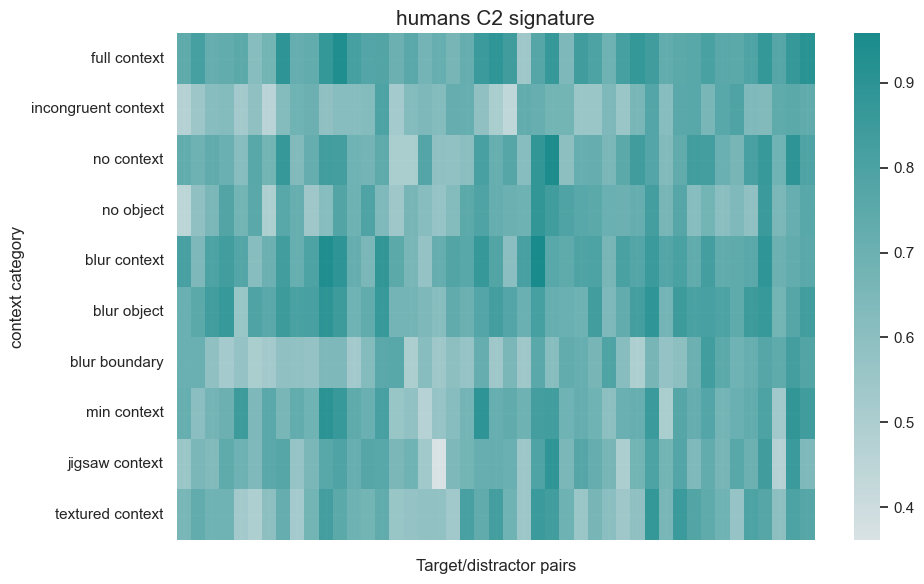

In [36]:
sns.set_theme(style="white")
for signature in ['C1', 'I1', 'C2']:
    for subject_name in ['monkeys', 'humans']:
        sns.set(rc={"figure.figsize":(10, 6) if signature == 'C2' else (2, 6)} )
        cmap_to_use = cmap_coral if subject_name == 'monkeys' else cmap_teal


        df=pd.DataFrame(beh_sig_sbj[signature][subject_name])
        g = sns.heatmap(df, cmap=cmap_to_use,linecolor='k', alpha=0.9, edgecolor='k')#,vmin=0.4,vmax=0.9)
        g.set_xticklabels('')
        g.set_ylabel('images grouped by object category' if signature == 'I1' or signature == 'I1n' else 'context category')
        g.set_title(f'{subject_name} {signature} signature', fontdict={'fontsize': 15})
        g.set_xlabel('Target/distractor pairs' if signature == 'C2' else '' )

        if signature == 'C1' or  signature == 'C2':
            g.set_yticklabels(list(context_to_num.keys()), rotation=0)

        plt.tight_layout()

        #plt.savefig(f'{signature}_{subject_name}_.pdf', format='pdf')
        plt.show()


In [10]:


save(beh_sig_sbj,'results/behavioral_signatures_primates')

In [11]:
full_decode_acc_models=pd.read_pickle('results/acc_all_models_3k_no_dd.pkl') 

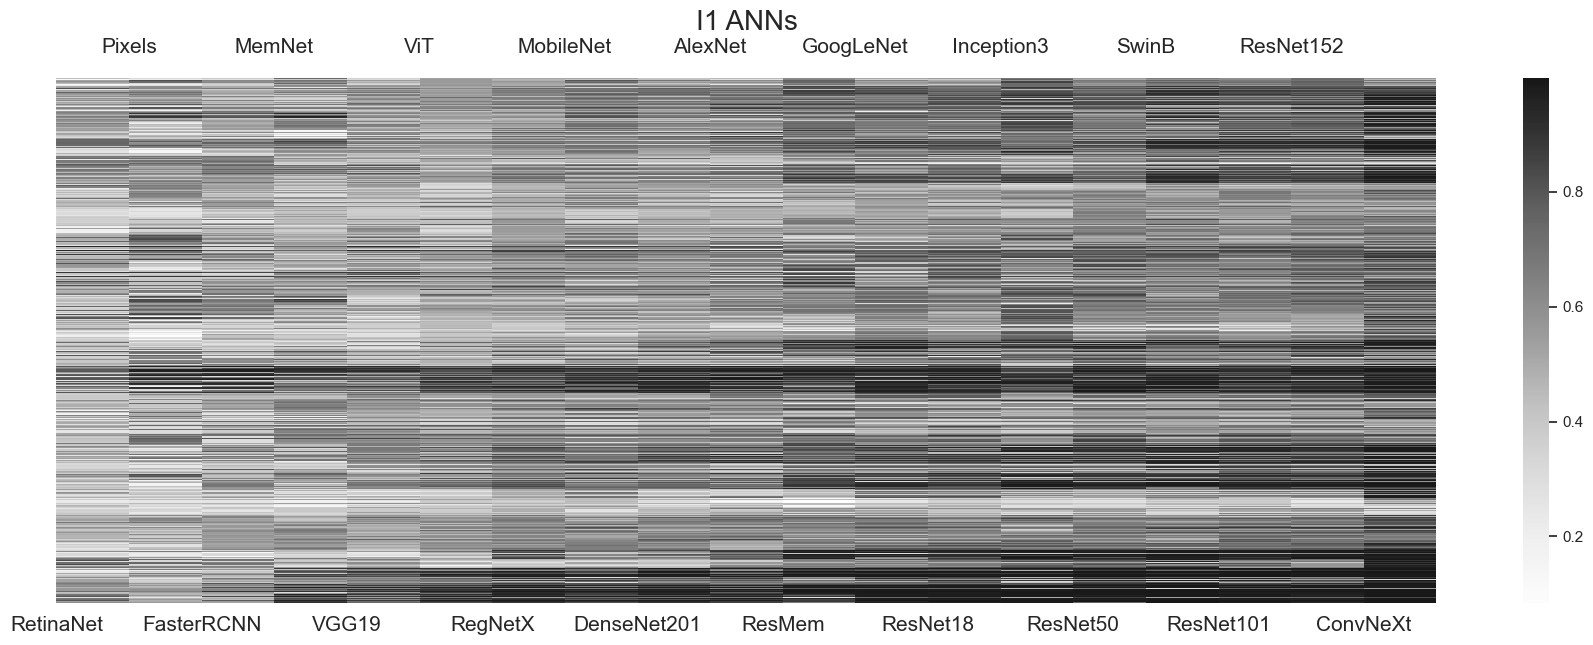

In [26]:
sns.set_theme(style="white")
signature = 'I1'
sns.set(rc={"figure.figsize":(10, 6) if signature == 'C2' else (18, 6)} )


subject_name = 'models'
df=pd.DataFrame(full_decode_acc_models)
sorted_ =list(df.mean().sort_values().index)
df=df[sorted_]
g = sns.heatmap(df, cmap='Greys',linecolor='k', alpha=0.9, edgecolor='k')#,vmin=0.4,vmax=0.9)
g.set_xticklabels(g.get_xticklabels(), fontsize=15, rotation=0)
plt.tight_layout()
labels=list(df.columns)
plt.xticks(range(len(labels)), labels, rotation=0)
g.set_title(f'{signature} ANNs', fontsize=20)
for i, label in enumerate(labels):
    if i % 2 == 1:
        plt.gca().get_xticklabels()[i].set_position((10, 1.1))
g.set_yticklabels([])

#plt.savefig(f'{signature}_{subject_name}_.pdf', format='pdf')
plt.show()



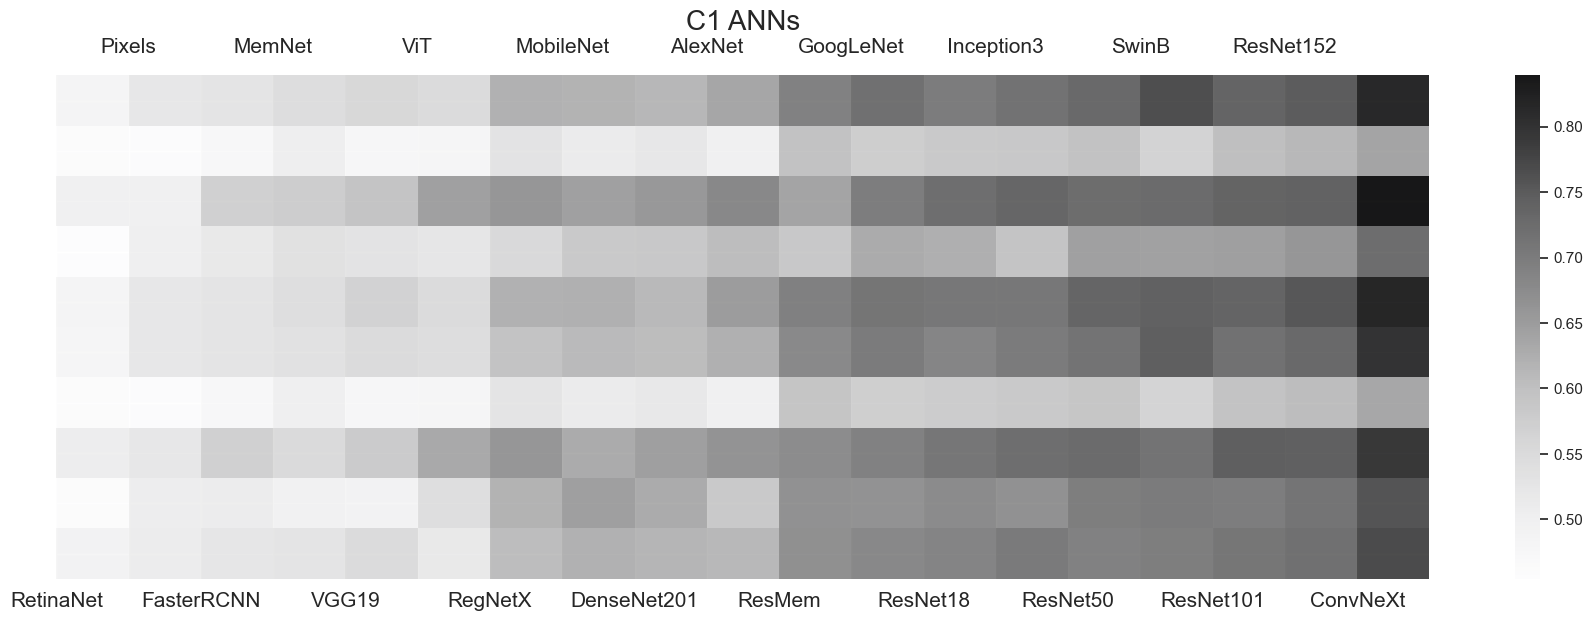

In [29]:
sns.set_theme(style="white")
signature = 'C1'
sns.set(rc={"figure.figsize":(10, 6) if signature == 'C2' else (18, 6)} )


subject_name = 'models'
df=pd.DataFrame(full_decode_acc_models)
sorted_ =list(df.mean().sort_values().index)
df['context']=df.index%10

df=df.groupby('context').agg(np.nanmean)
df=df[sorted_]

g = sns.heatmap(df, cmap='Greys',linecolor='k', alpha=0.9, edgecolor='k')#,vmin=0.4,vmax=0.9)
g.set_xticklabels(g.get_xticklabels(), fontsize=15, rotation=0)
g.set_title(f'{signature} ANNs', fontsize=20)


plt.tight_layout()
labels=list(df.columns)
plt.xticks(range(len(labels)), labels, rotation=0)

for i, label in enumerate(labels):
    if i % 2 == 1:
        plt.gca().get_xticklabels()[i].set_position((10, 1.1))
g.set_yticklabels([])
g.set_ylabel('')
#plt.savefig(f'{signature}_{subject_name}_.pdf', format='pdf')
plt.show()


